In [1]:
import ml_func as ml

train_filename = "escape_school_cta_data_train.h5"
ml.download_file("https://nextcloud.e5.physik.tu-dortmund.de/index.php/s/Kz3EbfbMAzyRHEa/download?path=%2Fparticipants&files=escape_school_cta_data_train.h5",
                 train_filename
                )

test_filename = "escape_school_cta_data_test_no_labels.h5"
ml.download_file("https://nextcloud.e5.physik.tu-dortmund.de/index.php/s/Kz3EbfbMAzyRHEa/download?path=%2Fparticipants&files=escape_school_cta_data_test_no_labels.h5",
                 test_filename,
                )
                


File escape_school_cta_data_train.h5 exists already
File escape_school_cta_data_test_no_labels.h5 exists already


# CTA data machine learning challenge


Notebook stolen and modified from https://github.com/tudo-astroparticlephysics/machine-learning-lecture/blob/main/smd_boosting.ipynb

main author: Maximilian Nöthe

additional authors: Thomas Vuillaume, Michaël Dell'aiera, Martino Sorbaro

## The challenge

In this exercise, you must train two models:
- one classifier to predict the type of particle
- one regressor to predict the energy of gamma events

You will apply the methods seen previously during the course and try to find the best model with the best hyperparameters.
At the end, you can apply your model to a test dataset with unknown labels and send your prediction back to us. We will then evaluate it and rank the predictions.


rules:
- You can only use models in scikit-learn.
- regression score will be computed using a logarithmic MSE
- classficiation score will be accuracy
- You must do you pull-request on the repository https://github.com/escape2020/school2022-mlctapred with your prediction before 10:30 today to be ranked.
- Tutors can participate, they can't win


In [2]:
import ml_func as ml

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap

In [3]:
pd.options.display.max_rows = 10
ml.set_plot_style()

# A Complete Example

Below we load a dataset containing data from simulated CTA Observations.

<img width="100%" src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/CTA_Telescopes_in_Southern_Hemisphere.jpg/1280px-CTA_Telescopes_in_Southern_Hemisphere.jpg" />   

We will perform the typical steps to build and evaluate a classifier.

0. Understand where your data comes from

1. Preprocessing
    * Drop Constant Values,
    * Handle Missing Data 
    * Feature Generation

2. Splitting
    
    * Split your data into training and evaluation sets
    
3. Training 
    
    * Train your classifier of choice.
    
4. Evaluation
    
    * Evaluate the performance on the test data set.
    * If not good enough, go back to step 1 
    
5. Physics
    
    * Check whether your data support your hypothesis
    

## 1. Get to know your data

Cherenkov telescopes record short flashes of light produced by very high energy cosmic rays and photons hitting earths atmosphere.

![](https://www.cta-observatory.org/wp-content/uploads/2016/05/cta47.png)

In [4]:
%%HTML
<!-- https://nextcloud.e5.physik.tu-dortmund.de/index.php/s/e7yb2mifGDeyDBN/download -->
<video width="100%" controls>
  <source src="./resources/fact_events.mp4" type="video/mp4">
</video>

We will use machine learning for two tasks in this example. 

 * Train a classifier to distinguish events induced by gamma rays form events induced by cosmic rays
 * Train a regressor to estimate the energy of the incoming primary particle.

## 2. Preprocess data

A lot of preprocessing has already happened at this point.

* Calibration of Raw Data
* Data Reduction from voltage timeseries per pixel to number of photons and mean time for each pixel
* Calculation of image features
* Geometrical Reconstruction of the Shower Geometry


Load data and remove unwanted columns and store the true labels separately.

In [5]:
train_df = pd.read_hdf(train_filename)

In [6]:
len(train_df.columns)

81

Check the data types of the columns. We can select non-numeric types and encode them. But in this case we might as well drop them as the attribute is not important.

In [7]:
c = train_df.select_dtypes(exclude=['number']).columns
print('Removed columns:', c.values)

train_df = train_df.drop(c, axis='columns')

Removed columns: ['name' 'type' 'camera_type' 'tel_description' 'time'
 'HillasReconstructor_is_valid']


We can spot the columns with constant values by looking at the standard deviation.

In [8]:
desc = train_df.describe()
desc

,obs_id,event_id,tel_id,hillas_intensity,hillas_skewness,hillas_kurtosis,hillas_fov_lon,hillas_fov_lat,hillas_r,hillas_phi,...,HillasReconstructor_core_uncert_x,HillasReconstructor_core_uncert_y,HillasReconstructor_core_tilted_x,HillasReconstructor_core_tilted_y,HillasReconstructor_core_tilted_uncert_x,HillasReconstructor_core_tilted_uncert_y,HillasReconstructor_h_max,HillasReconstructor_h_max_uncert,HillasReconstructor_average_intensity,HillasReconstructor_goodness_of_fit
count,191576.000000,1.915760e+05,191576.000000,1.447880e+05,144788.000000,144788.000000,144788.000000,144788.000000,144788.000000,144788.000000,...,0.0,0.0,118174.000000,118174.000000,0.0,0.0,1.181740e+05,0.0,118174.000000,0.0
mean,4034.415877,2.505329e+06,9.781852,1.406573e+03,-0.001422,2.338269,0.008467,-0.002987,2.358293,-0.314722,...,NaN,NaN,-48.463258,-13.758924,NaN,NaN,8.897712e+03,NaN,1971.285419,NaN
std,4307.906126,1.436463e+06,8.880496,1.234515e+04,0.484921,0.835964,1.806007,1.805688,0.980137,103.765748,...,NaN,NaN,1425.853374,2305.360433,NaN,NaN,1.534817e+04,NaN,9743.990810,NaN
min,6.000000,1.000000e+02,1.000000,5.000156e+01,-4.580820,1.000378,-3.740020,-4.054932,0.008485,-179.998728,...,NaN,NaN,-228586.452946,-256916.817413,NaN,NaN,5.331505e+01,NaN,51.809884,NaN
25%,564.000000,1.262382e+06,4.000000,9.452853e+01,-0.275556,1.910261,-1.345421,-1.362219,1.604686,-89.745863,...,NaN,NaN,-139.373119,-154.105380,NaN,NaN,6.957040e+03,NaN,178.606041,NaN
50%,1303.000000,2.522114e+06,8.000000,1.885668e+02,-0.001402,2.192070,0.017027,-0.009350,2.319740,-0.708060,...,NaN,NaN,-31.288321,-21.744096,NaN,NaN,8.566593e+03,NaN,366.401119,NaN
75%,7503.000000,3.747716e+06,11.000000,5.180995e+02,0.274656,2.567369,1.353119,1.362149,3.254738,89.052235,...,NaN,NaN,69.321668,97.253091,NaN,NaN,1.023198e+04,NaN,933.568718,NaN
max,12934.000000,5.000017e+06,35.000000,1.040606e+06,4.738561,36.195741,3.741765,4.054217,4.085122,179.990397,...,NaN,NaN,42685.665862,229151.504332,NaN,NaN,2.802989e+06,NaN,334123.535908,NaN


In [9]:
c = desc.columns[desc.loc['std'] == 0]
print('Removed columns:', c.values)
train_df = train_df.drop(c, axis='columns')

Removed columns: ['num_mirrors' 'event_type']


drop columns where all rows are nan

In [10]:
c = train_df.columns[train_df.count() == 0]
print('Removed columns:', c.values)
train_df = train_df.drop(c, axis='columns')

Removed columns: ['HillasReconstructor_core_uncert_x' 'HillasReconstructor_core_uncert_y'
 'HillasReconstructor_core_tilted_uncert_x'
 'HillasReconstructor_core_tilted_uncert_y'
 'HillasReconstructor_h_max_uncert' 'HillasReconstructor_goodness_of_fit']


Check for missing data. (Just delete it in this case)

In [11]:
print(len(train_df))
train_df = train_df.dropna()
print(len(train_df))

191576
89321


In [12]:
def preprocess(df):
    """ 
    All the preprocessing in one function
    """
    
    c = df.select_dtypes(exclude=['number']).columns
    df = df.drop(c, axis='columns')
    
    c = df.columns[df.count() == 0]
    df = df.drop(c, axis='columns')
    
    desc = df.describe()
    
    c = desc.columns[desc.loc['std'] == 0]
    df = df.drop(c, axis='columns')
    
    df = df.dropna()
    
    return df

Now we can perform feature generation. We use our expert knowledge or intuition to create a new feature by combining existing columns into a new variable.

In [13]:
def feature_generation(df):
    df['awesome_feature'] =  df['hillas_intensity'] * (df['hillas_width'] / df['hillas_length'])
    
    # distance of impact point to the telescope
    df['impact'] = np.sqrt(
        (df['HillasReconstructor_core_x'] - df['pos_x'])**2
        + (df['HillasReconstructor_core_y'] - df['pos_y'])**2
    )
    return df

train_df = feature_generation(train_df)

train_df[['awesome_feature', 'impact']]

,awesome_feature,impact
0,153.073770,521.449692
2,95.360931,667.462295
3,37.787895,631.265012
5,65.383803,159.406527
6,44.162487,65.933890
...,...,...
99607,57.323947,622.227452
99608,54.572369,357.782269
99609,44.360092,16.751592
99610,34.471839,204.048956


## 3. A quick look at the data

First we can divide the data in two datasets, based on the type of particles, gammas or protons

In [14]:
gammas = train_df[train_df.true_shower_primary_id==0]
protons = train_df[train_df.true_shower_primary_id==101]

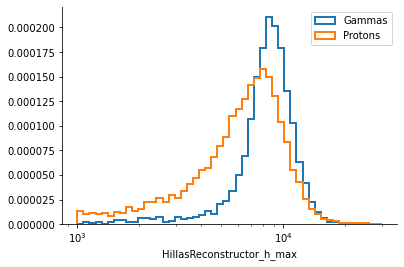

In [15]:
bins = np.linspace(-20, 20, 100)
# bins = np.logspace(0, 1, 100)
# bins = 100
bins = np.arange(0, 10) - 0.5
bins = np.geomspace(1e3, 30e3, 51)

col = 'HillasReconstructor_h_max'

plt.figure()
plt.hist(gammas[col], bins=bins, histtype='step', lw=2, label='Gammas', density=True)
plt.hist(protons[col], bins=bins, histtype='step', lw=2, label='Protons', density=True)
plt.xscale('log')
plt.xlabel(col)
plt.legend()
None

### Exercise
You may plot other histograms or scatter plots to get a better grasp at the data.

## 4. Train a regressor to reconstruct the gammas energy

In [16]:
# we select the training features by removing columns with `true_` values coming from the simulation
training_features = [name for name in list(gammas.columns) if not name.startswith('true_')]
predict_feature = 'true_energy'  # replace with the simulated energy column name

training_features.remove('obs_id')
training_features.remove('event_id')
training_features

['tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 'hillas_fov_lon',
 'hillas_fov_lat',
 'hillas_r',
 'hillas_phi',
 'hillas_length',
 'hillas_length_uncertainty',
 'hillas_width',
 'hillas_width_uncertainty',
 'hillas_psi',
 'timing_intercept',
 'timing_deviation',
 'timing_slope',
 'leakage_pixels_width_1',
 'leakage_pixels_width_2',
 'leakage_intensity_width_1',
 'leakage_intensity_width_2',
 'concentration_cog',
 'concentration_core',
 'concentration_pixel',
 'morphology_num_pixels',
 'morphology_num_islands',
 'morphology_num_small_islands',
 'morphology_num_medium_islands',
 'morphology_num_large_islands',
 'intensity_max',
 'intensity_min',
 'intensity_mean',
 'intensity_std',
 'intensity_skewness',
 'intensity_kurtosis',
 'peak_time_max',
 'peak_time_min',
 'peak_time_mean',
 'peak_time_std',
 'peak_time_skewness',
 'peak_time_kurtosis',
 'core_psi',
 'pos_x',
 'pos_y',
 'pos_z',
 'mirror_area',
 'num_mirror_tiles',
 'equivalent_focal_length',
 'HillasReco

In [17]:
# Implement the train / test split for X,y

X = gammas[training_features]
y = gammas[predict_feature]


1. Divide your dataset into train and validation
1. Fit a `DecisionTree` to do the regression of the energy on gammas
1. Apply the trained model to the test dataset
1. Evaluate the goodness of your prediction using a logarithmic MSE
1. Extra: How can we improve that regression?

In [18]:
from sklearn.tree import ??

SyntaxError: invalid syntax (1779053316.py, line 1)

In [19]:

X = gammas[training_features]
y = gammas[predict_feature]


train_test_split(???)


SyntaxError: invalid syntax (692700143.py, line 5)

In [20]:
reg = ???
reg.fit(X_train, y_train)

SyntaxError: invalid syntax (486543896.py, line 1)

In [21]:
y_predict = ???

SyntaxError: invalid syntax (153931060.py, line 1)

## 5. Train a classifier to do gamma/hadron separation

Data preparation for gamma/hadron classification

Execise: split the data into train / test using sklearn

At this point we combine the two datasets into one big matrix and build a label vector $y$

In [22]:
X = train_df[training_features]
y = np.concatenate([np.ones(len(gammas)), np.zeros(len(protons))])

In [23]:
from sklearn.model_selection import train_test_split

X_test, X_train, y_test, y_train = train_test_split(X, y)

### Train the classifier

Now we can train any classifier we want on the prepared data.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

names = [
    # "Nearest Neighbors",
    # "Linear SVM",
    # "RBF SVM",
    # "Gaussian Process",
    # "Decision Tree",
    "Random Forest",
    # "Neural Net",
    # "AdaBoost",
    # "Naive Bayes",
    # "QDA",
]

classifiers = [
    # SVC(kernel="linear", C=0.025),
    # SVC(gamma=2, C=1),
    # GaussianProcessClassifier(1.0 * RBF(1.0)),
    # DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators=200,  max_depth=25, criterion='entropy'),
    # MLPClassifier(alpha=1, max_iter=100),
    # AdaBoostClassifier(),
    # GaussianNB(),
    # QuadraticDiscriminantAnalysis(),
]

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(name,score)
    
rfc = classifiers[0]

Random Forest 0.8427526496492014


In [ ]:
# Random Forest 0.8396924914166294
# Neural Net 0.7445141065830722
# AdaBoost 0.7948947604120018
# Naive Bayes 0.49791013584117033
# QDA 0.5668308702791461

1. Train the `DecisionTreeClassifier`
2. This time get the prediction **proba** on the test dataset

### Classifier Evaluation 

Check accuracy of the models and other metrics 

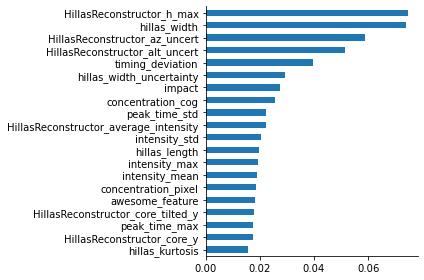

In [38]:

importance = pd.Series(rfc.feature_importances_, index=training_features)



plt.figure()
importance.sort_values().tail(20).plot.barh()
plt.tight_layout()

In [41]:
y_test

array([1., 0., 1., ..., 0., 1., 1.])

In [47]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
y_pred = rfc.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print(acc)
auc = roc_auc_score(y_test,y_pred)
print(auc)
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])


0.8427526496492014
0.842308848387691


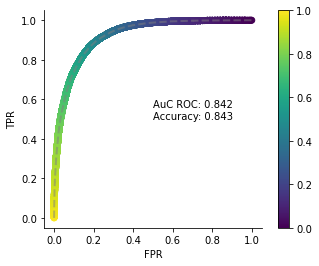

In [48]:

plt.figure()
plt.scatter(fpr, tpr, c=thresholds, vmax=1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.gca().set_aspect(1)
plt.plot(fpr, tpr, '--', color='gray', alpha=0.5)
plt.text(0.5, 0.5, f'AuC ROC: {auc:0.03f} \nAccuracy: {acc:0.03f}')
plt.colorbar()
None

## 8. Redo, using cross-validation

## 9. Apply your best model to the test dataset

In [ ]:
test_df = pd.read_hdf(test_filename)

In [ ]:
test_df['reco_energy'] = ##
test_df['reco_type'] = ##

In [ ]:
ml.save_prediction(test_df, yourname)

### ⏱ SEND IT ⏱ 

## 10. Physics

Now we could test our model and our hypothesis on real observed data. This part of the analysis is the most time 
consuming in general. It also requires more data than than this notebook can handle. 
After careful analysis one can produce an image of the gamma-ray sky

<img width="60%" src="https://www.mpi-hd.mpg.de/hfm/HESS/hgps/figures/HESS_J1813m126.png">

## 10. Extra: Improving Classification


### Boosting and AdaBoost

Similar to the idea of combining many classifiers through bagging (like we did for the RandomForests) we now 
train many estimators in a sequential manner. In each iteration the data gets modified slightly using weights $w$
for each sample in the training data. In the first iteration the weights are all set to $w=1$

In each successive iteration the weights are updated. The samples that were incorrectly classified in the previous 
iteration get a higher weight. The weights for correctly classified samples get decreases. 
In other words: We increase the influence/importance of samples that are difficult to classify.

Predictions are performed by taking a weighted average of the single predictors.

The popular AdaBoost algorithms takes this a step further by optimizing the weight of each separate classifier 
in the ensemble.
The AdaBoost ensemble combines many learners in an iterative way. The learner at iteration $m$ is:

$$
 F_{m}(x)=F_{m-1}(x)+\gamma _{m}h_{m}(x)
$$

The choice of $F_0$ is problem specific.

Each weak learner produces a prediction $h(x_{m})$ for each sample in the training set. At each iteration $m$ a 
weak learner is fitted and assigned a coefficient $\gamma_{m}$ which is found by minimizing:

$$
\gamma_m = {\underset {\gamma }{\arg \min }} \sum_{i}^{N}E\bigl(F_{m-1}(x_{i})+\gamma h(x_{i})\bigr)
$$

where $E(F)$ is some error function and $x_i$ is the reweighted data sample.

In general this method can work with any classifying method. Traditionally it is being used with very small 
decision trees. 
The weights get used to select the split points during the minimization of the loss function in each node

$$
 \underset{(X, s) \in \, \mathbf{X} \times {S}}{\arg \max} IG(X,Y) =   \underset{(X, s) \in \, \mathbf{X} \times {S}}{\arg \max} ( H(Y) - H(Y |\, X) ).
$$

Below we try AdaBoost on the CTA data.


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=100,
    learning_rate=0.5,
)
ada.fit(X_train, y_train)

y_prediction = ada.predict(X_test)
y_prediction_proba = ada.predict_proba(X_test)

In [ ]:
scores = np.array(list(ada.staged_score(X_test, y_test)))

plt.figure()
plt.plot(scores, '.')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
None

In [ ]:
acc = accuracy_score(y_test, y_prediction)
auc = roc_auc_score(y_test, y_prediction_proba[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_prediction_proba[:, 1])

plt.figure()
plt.scatter(fpr, tpr, c=thresholds)
plt.plot(fpr, tpr, '--', color='gray', alpha=0.5)
plt.text(0.5, 0.5, f'AuC ROC: {auc:0.03f} \nAccuracy: {acc:0.03f}')
None

### Gradient Boosting 

Very similar to AdaBoost. Only this time we change the target label we train the classifiers for.

Formulate the general problem as follows (See Wikipedia):

Starts with a constant function $F_{0}(x)$ and some differentiable loss function $L$ and incrementally expands it in a greedy fashion:

$$
F_{0}(x)={\underset {\gamma }{\arg \min }}{\sum _{i=1}^{n}{L(y_{i},\gamma )}}
$$

$$
F_{m}(x)=F_{m-1}(x)+{\underset {h_{m}\in {\mathcal {H}}}{\operatorname {arg\,min} }}\left[{\sum _{i=1}^{n}{L(y_{i},F_{m-1}(x_{i})+h_{m}(x_{i}))}}\right]
$$

Finding the best $ h_{m}\in {\mathcal {H}}$ is computationally speaking impossible.
If we could find the perfect $h$ however, we know that 

$$
F_{m+1}(x_i)=F_{m}(x_i)+h(x_i)=y_i
$$

or, equivalently, 

$$
   h(x_i)= y_i - F_{m}(x_i)
$$

Note that for the mean squared error loss $\frac{1}{2}(y_i - F(x_i))^2$ this is equivalent to the negative 
gradient with respect to $F_i$.

For a general loss function we fit $h_{m}(x)$ to the residuals, or negative gradients 
$$
 r_{i, m}=-\left[{\frac {\partial L(y_{i},F(x_{i}))}{\partial F(x_{i})}}\right]_{F(x)=F_{m-1}(x)}\quad {\mbox{for }}i=1,\ldots ,n.
$$



Below we try it on CTA data again.


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

grb = GradientBoostingClassifier(
    verbose=True,
    n_estimators=300,
)
grb.fit(X_train, y_train)

y_prediction = grb.predict(X_test)
y_prediction_proba = grb.predict_proba(X_test)

In [ ]:
l = [accuracy_score(y_pred, y_test) for y_pred in grb.staged_predict(X_test)]

plt.figure()
plt.plot(range(len(l)), l, '.')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
None

In [ ]:
acc = accuracy_score(y_test, y_prediction)
auc = roc_auc_score(y_test, y_prediction_proba[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_prediction_proba[:, 1])

plt.figure()
plt.scatter(fpr, tpr, c=thresholds)
plt.plot(fpr, tpr, '--', color='gray', alpha=0.5)
plt.text(0.5, 0.5, f'AuC ROC: {auc:0.03f} \nAccuracy: {acc:0.03f}')
None

More on gradient descent algorithms can be found in the Neural Network lecture.

Let's now test our all time favorite classifier. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150,  max_depth=18, criterion='entropy')
rf.fit(X_train, y_train)

y_prediction = rf.predict(X_test)
y_prediction_proba = rf.predict_proba(X_test)

In [ ]:
acc = accuracy_score(y_test, y_prediction)
auc = roc_auc_score(y_test, y_prediction_proba[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_prediction_proba[:, 1])

plt.figure()
plt.scatter(fpr, tpr, c=thresholds)
plt.plot(fpr, tpr, '--', color='gray', alpha=0.5)
plt.text(0.5, 0.5, f'AuC ROC: {auc:0.03f} \nAccuracy: {acc:0.03f}')
None